
### Extra Credit Assignment (5 points)
**Deadline:** Friday, April 5, 2019 11:59:59pm. I will create an assignment on Classes, where you can submit your results.

As part of this assignment, there is an attached zip file containing two files: `reviews/reviews_train.tsv` and `reviews/reviews_test.tsv`. Each file contains a number of lines. Each line is separated by a **tab value**. The first part of the line is a piece of text (a "review"). The second part of the line is an integer value, from 1 to 5, corresponding to the star rating that was given alongside the review.

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

* First, you will need to upload these files to your JupyterHub Notebook server. You can upload files by simple drag 'n' drop, or by using the "Upload" button.

* You will use the `reviews_train.tsv` file to train various classification models (see below). You will then use the trained model(s) on the `reviews_test.tsv` file to test their performance.

In [2]:
# open file and clean up data
with open('reviews_train.tsv', encoding="utf8") as tr:
    train_rawdata = [x_tr.strip().split("\t") for x_tr in tr.readlines()] 
    train_data_cleaned = []
    for data in train_rawdata:
        tr_cleaned = {'text': data[0], 'label': int(float(data[1]))}
        train_data_cleaned.append(tr_cleaned)
        
train_data = pd.DataFrame(train_data_cleaned)

with open('reviews_test.tsv', encoding="utf8") as te:
    test_rawdata = [x_te.strip().split("\t") for x_te in te.readlines()] 
    test_data_cleaned = []
    for data in test_rawdata:
        te_cleaned = {'text': data[0], 'label': int(float(data[1]))}
        test_data_cleaned.append(te_cleaned)
        
test_data = pd.DataFrame(test_data_cleaned)

In [3]:
print(' ======= TRAIN DATA ======= \n', train_data.head(3))
print(' \n ======= TEST DATA ======= \n', test_data.head(3))

 ======= TRAIN DATA ======= 
    label                                               text
0      4  Proximity to waterfront and downtown Seattle. ...
1      4  Clean, shopping near by, very pleasant staff, ...
2      5  Everything about our stay was great. Traveling...
 
 ======= TEST DATA ======= 
    label                                               text
0      5  This was our first time visiting the city of N...
1      5  Excellent service, great size rooms and great ...
2      5  Great new hotel with amazing access to shoppin...


In [4]:
train_x = train_data['text']
train_y = train_data['label']
test_x = test_data['text']
test_y = test_data['label']

test_sc2 = test_data.loc[test_data['label'] == 2]
test_x2 = test_sc2['text']
test_y2 = test_sc2['label']

test_sc5 = test_data.loc[test_data['label'] == 5]
test_x5 = test_sc5['text']
test_y5 = test_sc5['label']

In particular, you will train your classifiers on the contents of the `reviews_train.tsv` file (text and label), as they are, meaning you will be working with 5 different classes (the different star ratings that show up in the file). You will train **4 different classifiers**. 

Each of those classifiers will be tested on the contents of the `reviews_test.tsv` file. For the evaluation, you will be using CRCs (Cumulative Response Curves). You will have to create **2 CRCs**.

Each CRC will demonstrate (in the same plot) the performance of each of the 4 classifiers on the `reviews_test.tsv`, when focusing on a _specific star rating_. You get to pick the star ratings to test. For example, if you pick "rating = 2", then the CRC will consider as correct classifications on the `reviews_test.tsv` the ratings that are equal to 2, and will consider as misclassification anything else.

Which two star ratings to show (one per CRC) is up to you. However, one rating must be below 3 and the other greater than or equal to 3. For example, you can pick to plot the pair ("Rating = 2", "Rating = 5"). You cannot pick both plots to be < 3 or both of them to be >= 3.

### Part I -- prepping the data for testing the 4 Classifiers
---

In [5]:
# transform/vectorize text to a matrix of binary outcomes
binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(train_x)

train_x_binary = binary_vectorizer.transform(train_x)
test_x_binary = binary_vectorizer.transform(test_x) 
test_x2_binary = binary_vectorizer.transform(test_x2) 
test_x5_binary = binary_vectorizer.transform(test_x5) 

# transform/vectorize text to a matrix of counted occurances
count_vectorizer = CountVectorizer()
count_vectorizer.fit(train_x)

train_x_count = count_vectorizer.transform(train_x)
test_x_count = count_vectorizer.transform(test_x)
test_x2_count = count_vectorizer.transform(test_x2)
test_x5_count = count_vectorizer.transform(test_x5)

# Tf-idf Representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train_x)

train_x_tfidf = tfidf_vectorizer.transform(train_x)
test_x_tfidf = tfidf_vectorizer.transform(test_x)
test_x2_tfidf = tfidf_vectorizer.transform(test_x2)
test_x5_tfidf = tfidf_vectorizer.transform(test_x5)

You can reuse the same classifiers in the two CRCs.


**Note 1:** When training your classifiers, you will have to train them on the dataset with the 5 different classes together. When testing, you will be focusing on a specific rating, one for each CRC that you generate.


**Note 2:** As you are dealing with text, you may consider the text representation transformation as a different "classifier". That is, you can consider the the `CountVectorizer` with binary feature values and the `CountVectorizer` with actual counts as two different "classifiers", even though you use, e.g., `LogisticRegression` for both of them. On the other hand, changing the complexity parameters of a classifier _alone_ is not considered a separate classifier for the purposes of this assignment.

### Part II -- learning the models and creating the CRCs
---

In [6]:
# Here's a method that trains and returns the CRC of a clasifier

def train_and_compute_crc( model, train_x , train_y, test_x, test_y ):

    # Train the model
    model.fit(train_x, train_y)

    # Let's get the probabilities. FOCUS ON THE POSITIVE CLASS
    probabilities = model.predict_proba(test_x)[:, 1]

    # Create a dataframe that we can conveniently manipulate
    model_df = pd.DataFrame(list(zip(probabilities, test_y)), columns=["PROBABILITY", "TRUE_CLASS"])

    # Sort the dataframe rows by the PROBABILITY
    model_df_sorted = model_df.sort_values(by=['PROBABILITY'], ascending=False)

    # Compute the CUMULATIVE correct responses up until the
    return model_df_sorted["TRUE_CLASS"].cumsum()

#### Applying the models

In [7]:
# Decision Tree Model
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=15)
dt_crc = train_and_compute_crc( dt_model, train_x_count, train_y, test_x_count, test_y )

# binary model
binary_model = LogisticRegression()
binary_model.fit(train_x_binary, train_y)

binary_crc = train_and_compute_crc( binary_model, train_x_binary, train_y, test_x_binary, test_y )

#counter model
count_model = LogisticRegression()
count_model.fit(train_x_count, train_y)

count_crc = train_and_compute_crc( count_model, train_x_count, train_y, test_x_count, test_y )

#tf-idf model
tfidf_model = LogisticRegression()
tfidf_model.fit(train_x_tfidf, train_y)

tfidf_crc = train_and_compute_crc( tfidf_model, train_x_tfidf, train_y, test_x_tfidf, test_y )

In [8]:
# for score 2

# Decision Tree Model
dt2_model = DecisionTreeClassifier(criterion='entropy', max_depth=15)
dt2_crc = train_and_compute_crc( dt2_model, train_x_count, train_y, test_x2_count, test_y2 )

# binary model
binary2_model = LogisticRegression()
binary2_model.fit(train_x_binary, train_y)

binary2_crc = train_and_compute_crc( binary2_model, train_x_binary, train_y, test_x2_binary, test_y2 )

#counter model
count2_model = LogisticRegression()
count2_model.fit(train_x_count, train_y)

count2_crc = train_and_compute_crc( count2_model, train_x_count, train_y, test_x2_count, test_y2 )

#tf-idf model
tfidf2_model = LogisticRegression()
tfidf2_model.fit(train_x_tfidf, train_y)

tfidf2_crc = train_and_compute_crc( tfidf2_model, train_x_tfidf, train_y, test_x2_tfidf, test_y2 )

In [9]:
# for score 5

# Decision Tree Model
dt5_model = DecisionTreeClassifier(criterion='entropy', max_depth=15)
dt5_crc = train_and_compute_crc( dt5_model, train_x_count, train_y, test_x5_count, test_y5 )

# binary model
binary5_model = LogisticRegression()
binary5_model.fit(train_x_binary, train_y)

binary5_crc = train_and_compute_crc( binary5_model, train_x_binary, train_y, test_x5_binary, test_y5 )

#counter model
count5_model = LogisticRegression()
count5_model.fit(train_x_count, train_y)

count5_crc = train_and_compute_crc( count5_model, train_x_count, train_y, test_x5_count, test_y5 )

#tf-idf model
tfidf5_model = LogisticRegression()
tfidf5_model.fit(train_x_tfidf, train_y)

tfidf5_crc = train_and_compute_crc( tfidf5_model, train_x_tfidf, train_y, test_x5_tfidf, test_y5 )

### Part III -- Plot of CRC for all four classifiers
---
Make sure that in your plots you specify which model corresponds to which line. Give a brief description of the results and say which model you would pick.

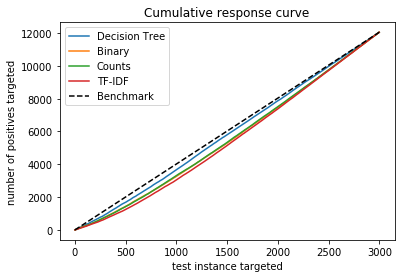

In [10]:
# Plot the above results in 1 graph
plt.plot(range(0, len(dt_crc)), dt_crc, label="Decision Tree")
plt.plot(range(0, len(binary_crc)), binary_crc, label="Binary")
plt.plot(range(0, len(count_crc)), count_crc, label="Counts")
plt.plot(range(0, len(tfidf_crc)), tfidf_crc, label="TF-IDF")
plt.plot([0,len(binary_crc)], [0,max(binary_crc)], 'k--', label="Benchmark")
plt.xlabel("test instance targeted")
plt.ylabel("number of positives targeted")
plt.title("Cumulative response curve")
plt.legend()
plt.show()

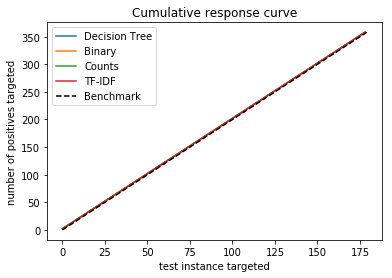

In [11]:
# Plot the above SCORE = 2 results in 1 graph
plt.plot(range(0, len(dt2_crc)), dt2_crc, label="Decision Tree")
plt.plot(range(0, len(binary2_crc)), binary2_crc, label="Binary")
plt.plot(range(0, len(count2_crc)), count2_crc, label="Counts")
plt.plot(range(0, len(tfidf2_crc)), tfidf2_crc, label="TF-IDF")
plt.plot([0,len(binary2_crc)], [0,max(binary2_crc)], 'k--', label="Benchmark")
plt.xlabel("test instance targeted")
plt.ylabel("number of positives targeted")
plt.title("Cumulative response curve")
plt.legend()
plt.show()

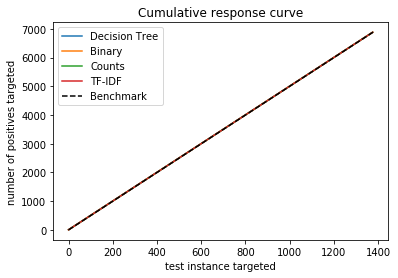

In [12]:
# Plot the above SCORE = 5 results in 1 graph
plt.plot(range(0, len(dt5_crc)), dt5_crc, label="Decision Tree")
plt.plot(range(0, len(binary5_crc)), binary5_crc, label="Binary")
plt.plot(range(0, len(count5_crc)), count5_crc, label="Counts")
plt.plot(range(0, len(tfidf5_crc)), tfidf5_crc, label="TF-IDF")
plt.plot([0,len(binary5_crc)], [0,max(binary5_crc)], 'k--', label="Benchmark")
plt.xlabel("test instance targeted")
plt.ylabel("number of positives targeted")
plt.title("Cumulative response curve")
plt.legend()
plt.show()

### Conclusion

I would choose the decision tree model since it shows the highest area under the CRC curve. However, if I separate the data according to their scores (2 and 5 in this case) and test them, the result does not seem to tell us much.  

---

## Useful note for the data

When dealing with text, it is often the case that we must work with Unicode characters. 

If you encounter the error: "ValueError: np.nan is an invalid document, expected byte or unicode string.". You are welcome to ask questions for the EC on the forums.

check the following url: https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document to help you resolve it.